In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 'normal' if x=='normal' else 'attack')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [4]:
df.shape

(125973, 44)

In [5]:
df['is_attack'].value_counts()

,count
is_attack,
normal,67343
attack,58630


In [6]:
df[df['hot'] > 0]['hot'].value_counts().sum()

2671

<Axes: xlabel='hot', ylabel='Density'>

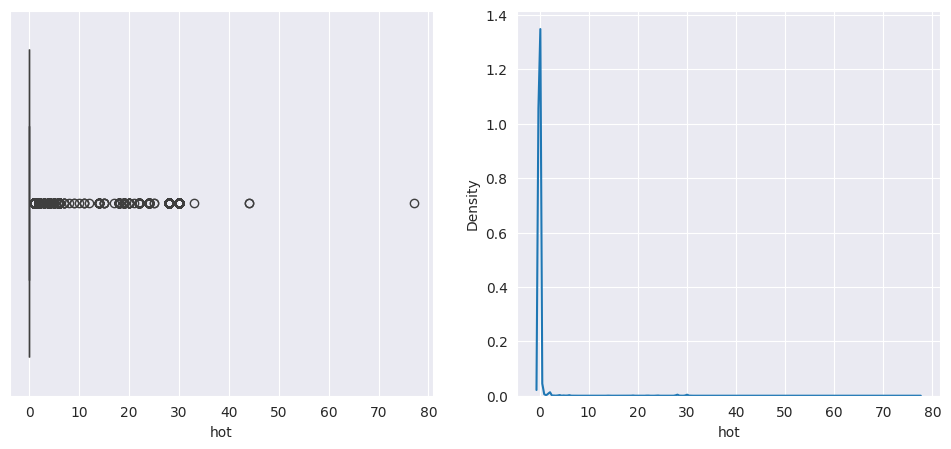

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='hot')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='hot')

In [8]:
np.percentile(df['hot'],75),np.percentile(df['hot'],50),np.percentile(df['hot'],25)

(0.0, 0.0, 0.0)

In [9]:
np.percentile(df['hot'],98)

1.0

In [10]:
IQR = np.percentile(df['hot'],75)-np.percentile(df['hot'],25)
ulimit = np.percentile(df['hot'],75) + 1.5*IQR
ulimit

0.0

In [11]:
not_outlier = df[df['hot'] <= ulimit].shape[0]
is_outlier = df[df['hot'] > ulimit].shape[0]
total_data = df.shape[0]
not_outlier,is_outlier,(not_outlier/total_data)*100, (is_outlier/total_data)*100

(123302, 2671, 97.87970438109753, 2.120295618902463)

In [12]:
hdf = df.copy()
hdf['is_hot'] = hdf['hot'].apply(lambda x: 1 if x > 0 else 0)
hdf['is_hot'].value_counts()

,count
is_hot,
0,123302
1,2671


In [13]:
pd.pivot_table(data=hdf,index='is_hot',columns='is_attack',values='duration',aggfunc='count',margins=True)

is_attack,attack,normal,All
is_hot,,,
0,57215,66087,123302
1,1415,1256,2671
All,58630,67343,125973


In [14]:
hattack = pd.pivot_table(data=hdf[hdf['is_attack'] != 'normal'],index='attack',columns='is_hot',values='duration',aggfunc='count',margins=True).reset_index().sort_values(1,ascending=False)
hattack[~hattack[1].isna()]

is_hot,attack,0,1,All
22,All,57215.0,1415.0,58630
0,back,9.0,947.0,956
20,warezclient,532.0,358.0,890
3,guess_passwd,1.0,52.0,53
1,buffer_overflow,8.0,22.0,30
16,satan,3624.0,9.0,3633
14,portsweep,2923.0,8.0,2931
7,loadmodule,5.0,4.0,9
8,multihop,3.0,4.0,7
12,phf,NaN,4.0,4


In [15]:
df[df['hot'] > 10]['is_attack'].value_counts()

,count
is_attack,
normal,524
attack,289


In [16]:
df[(df['hot'] <= 10) & (df['hot'] >=1)]['is_attack'].value_counts()

,count
is_attack,
attack,1126
normal,732


In [17]:
pd.pivot_table(data=hdf[(hdf['hot'] <= 10) & (hdf['hot'] >=1)],index='is_hot',columns='attack',values='duration',aggfunc='count')

attack,back,buffer_overflow,ftp_write,guess_passwd,imap,loadmodule,multihop,normal,phf,portsweep,rootkit,satan,warezclient
is_hot,,,,,,,,,,,,,
1,947,22,2,52,2,4,3,732,4,8,2,9,71


In [18]:
pd.pivot_table(data=hdf[hdf['hot'] > 10],index='is_hot',columns='attack',values='duration',aggfunc='count')

attack,multihop,normal,warezclient,warezmaster
is_hot,,,,
1,1,524,287,1


In [19]:
hcounts = df['hot'].value_counts().sort_index()

hcounts.drop(0,axis=0,inplace=True)

hcounts[hcounts.index<=10].sum()

1858

In [20]:
hcounts[hcounts.index>10].sum()

813

In [21]:
df[df['attack'] == 'back']['hot'].value_counts()

,count
hot,
2,881
1,64
0,9
3,2


In [22]:
df[df['attack'] == 'guess_passwd']['hot'].value_counts()

,count
hot,
1,48
2,4
0,1


In [23]:
df['numfailedlogins'].value_counts()

,count
numfailedlogins,
0,125851
1,104
2,9
3,5
4,3
5,1


<Axes: xlabel='numfailedlogins', ylabel='Density'>

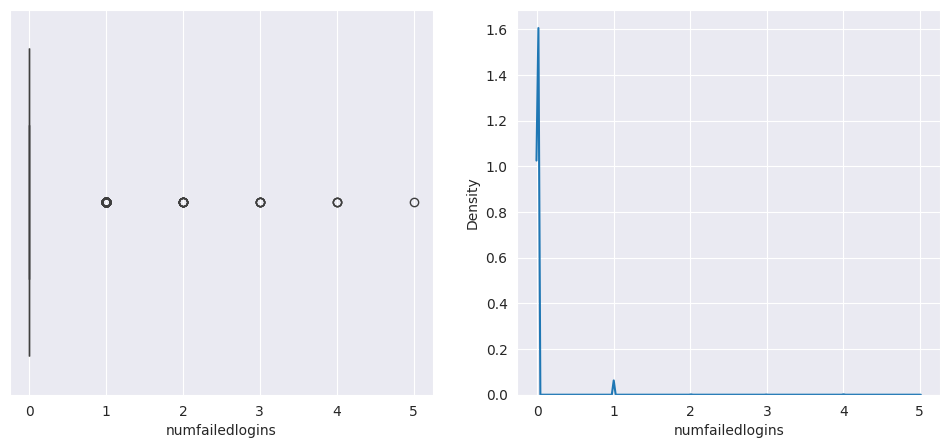

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='numfailedlogins')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='numfailedlogins')

In [25]:
np.percentile(df['numfailedlogins'],75),np.percentile(df['numfailedlogins'],50),np.percentile(df['numfailedlogins'],25)

(0.0, 0.0, 0.0)

In [26]:
np.percentile(df['numfailedlogins'],99)

0.0

In [27]:
fldf = df.copy()
fldf['login_failed'] = fldf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
fldf['is_hot'] = fldf['hot'].apply(lambda x: 1 if x > 0 else 0)
fldf.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack,login_failed,is_hot
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,0,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,attack,0,0
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,0,0


In [28]:
fldf['numfailedlogins'].value_counts()

,count
numfailedlogins,
0,125851
1,104
2,9
3,5
4,3
5,1


In [29]:
pd.pivot_table(data=fldf,index='login_failed',columns='is_attack',values='duration',aggfunc='count',margins=True)

is_attack,attack,normal,All
login_failed,,,
0,58576,67275,125851
1,54,68,122
All,58630,67343,125973


In [30]:
pd.pivot_table(data=fldf[fldf['attack'] != 'normal'],index='login_failed',columns='is_hot',values='duration',aggfunc='count')

is_hot,0,1
login_failed,,
0,57213,1363
1,2,52


In [31]:
pd.pivot_table(data=fldf[fldf['attack'] != 'normal'],index='numfailedlogins',columns='is_hot',values='duration',aggfunc='count')

is_hot,0,1
numfailedlogins,,
0,57213.0,1363.0
1,1.0,51.0
4,NaN,1.0
5,1.0,NaN


In [32]:
flattack = pd.pivot_table(data=fldf[fldf['is_attack'] != 'normal'],index='attack',columns='login_failed',values='duration',aggfunc='count',margins=True).reset_index().sort_values(1,ascending=False)
flattack.head(5)

login_failed,attack,0,1,All
22,All,58576.0,54.0,58630
3,guess_passwd,1.0,52.0,53
15,rootkit,9.0,1.0,10
16,satan,3632.0,1.0,3633
0,back,956.0,NaN,956


<Axes: xlabel='hot', ylabel='numfailedlogins'>

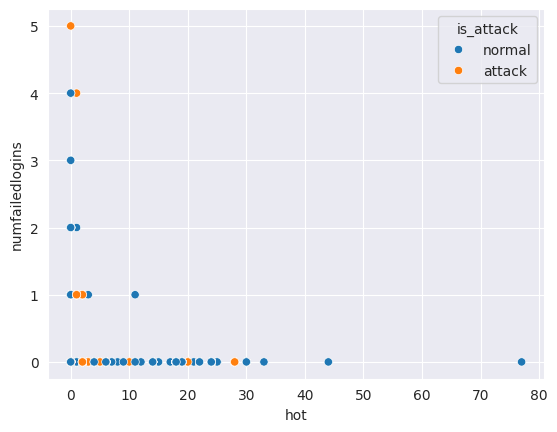

In [33]:
sns.scatterplot(data=df,x='hot',y='numfailedlogins',hue='is_attack')

In [34]:
df['loggedin'].value_counts()

,count
loggedin,
0,76121
1,49852


In [35]:
pd.pivot_table(data=df,index='loggedin',columns='is_attack',values='duration',aggfunc='count',margins=True)

is_attack,attack,normal,All
loggedin,,,
0,56635,19486,76121
1,1995,47857,49852
All,58630,67343,125973


In [36]:
pd.pivot_table(data=df,index='attack',columns='loggedin',values='duration',aggfunc='count',margins=True)

loggedin,0,1,All
attack,,,
back,NaN,956.0,956
buffer_overflow,NaN,30.0,30
ftp_write,2.0,6.0,8
guess_passwd,52.0,1.0,53
imap,10.0,1.0,11
ipsweep,3574.0,25.0,3599
land,18.0,NaN,18
loadmodule,1.0,8.0,9
multihop,3.0,4.0,7


In [37]:
ldf = df.copy()
ldf['login_failed'] = ldf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
ldf['is_hot'] = ldf['hot'].apply(lambda x: 1 if x > 0 else 0)

In [38]:
pd.pivot_table(data=ldf[(ldf['loggedin'] == 0) & (ldf['attack'] != 'normal')],index='attack',columns='loggedin',values='duration',aggfunc='count').sort_values(0,ascending=False).T

attack,neptune,satan,ipsweep,portsweep,smurf,nmap,teardrop,pod,guess_passwd,warezmaster,land,imap,rootkit,multihop,ftp_write,loadmodule,spy
loggedin,,,,,,,,,,,,,,,,,
0,41213,3578,3574,2928,2646,1493,892,201,52,18,18,10,5,3,2,1,1


In [39]:
pd.pivot_table(data=ldf[(ldf['loggedin'] == 1) & (ldf['attack'] != 'normal')],index='attack',columns='loggedin',values='duration',aggfunc='count').sort_values(1,ascending=False).T

attack,back,warezclient,satan,buffer_overflow,ipsweep,loadmodule,ftp_write,rootkit,multihop,phf,perl,portsweep,warezmaster,imap,spy,guess_passwd,neptune
loggedin,,,,,,,,,,,,,,,,,
1,956,890,55,30,25,8,6,5,4,4,3,3,2,1,1,1,1


In [40]:
pd.pivot_table(data=ldf,index='loggedin',columns='login_failed',values='duration',aggfunc='count',margins=True)

login_failed,0,1,All
loggedin,,,
0,76026,95,76121
1,49825,27,49852
All,125851,122,125973


In [41]:
pd.pivot_table(data=ldf,index='loggedin',columns='is_hot',values='duration',aggfunc='count',margins=True)

is_hot,0,1,All
loggedin,,,
0,76031,90,76121
1,47271,2581,49852
All,123302,2671,125973


In [42]:
pd.pivot_table(data=ldf[ldf['attack'] != 'normal'],index='loggedin',columns='is_hot',values='duration',aggfunc='count',margins=True)

is_hot,0,1,All
loggedin,,,
0,56568,67,56635
1,647,1348,1995
All,57215,1415,58630


In [43]:
ldf[(ldf['loggedin'] == 0) & (ldf['is_hot'] == 1)]['attack'].value_counts()

,count
attack,
guess_passwd,51
normal,23
portsweep,7
satan,7
imap,2


In [44]:
ldf[(ldf['loggedin'] == 1) & (ldf['is_hot'] == 1)]['attack'].value_counts()

,count
attack,
normal,1233
back,947
warezclient,358
buffer_overflow,22
multihop,4
phf,4
loadmodule,4
ftp_write,2
rootkit,2


In [45]:
df['numcompromised'].value_counts()

,count
numcompromised,
0,124687
1,976
2,98
4,40
3,38
...,...
7479,1
307,1
40,1


In [59]:
df['numcompromised'].nunique()

88

In [51]:
df[df['numcompromised'] > 0].value_counts().sum()

1286

In [52]:
np.percentile(df['numcompromised'],75),np.percentile(df['numcompromised'],50),np.percentile(df['numcompromised'],25)

(0.0, 0.0, 0.0)

In [55]:
np.percentile(df['numcompromised'],99)

1.0

<Axes: xlabel='numcompromised', ylabel='Density'>

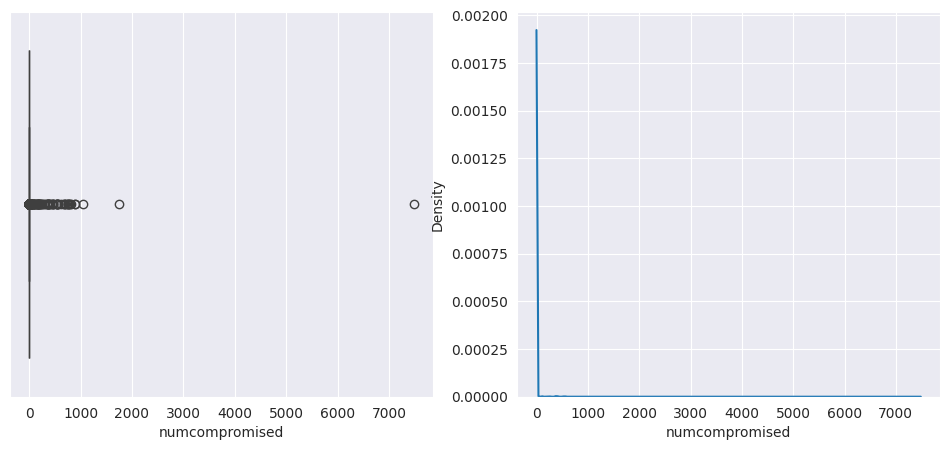

In [50]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='numcompromised')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='numcompromised')

In [46]:
ncdf = df.copy()
ncdf['login_failed'] = ncdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
ncdf['is_hot'] = ncdf['hot'].apply(lambda x: 1 if x > 0 else 0)
ncdf['is_compromised'] = ncdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)

In [47]:
pd.pivot_table(data=ncdf,index='is_compromised',columns='is_attack',values='duration',aggfunc='count')

is_attack,attack,normal
is_compromised,,
0,57716,66971
1,914,372


In [83]:
pd.pivot_table(data=ncdf,index='attack',columns='is_compromised',values='duration',aggfunc='count').reset_index().sort_values(1,ascending=False)

is_compromised,attack,0,1
0,back,73.0,883.0
11,normal,66971.0,372.0
1,buffer_overflow,12.0,18.0
16,rootkit,7.0,3.0
17,satan,3630.0,3.0
7,loadmodule,7.0,2.0
8,multihop,5.0,2.0
2,ftp_write,7.0,1.0
4,imap,10.0,1.0
5,ipsweep,3598.0,1.0


In [57]:
ncdf[(ncdf['numcompromised']>0) & (ncdf['numcompromised']<=10)]['attack'].value_counts()

,count
attack,
back,883
normal,290
buffer_overflow,18
rootkit,3
satan,3
loadmodule,2
ipsweep,1
ftp_write,1


In [58]:
pd.DataFrame(ncdf['numcompromised'].describe()).T

,count,mean,std,min,25%,50%,75%,max
numcompromised,125973.0,0.27925,23.942042,0.0,0.0,0.0,0.0,7479.0


In [86]:
ncdf['compromised_bins'] = None
for i in range(len(ncdf)):
  comp = ncdf.loc[i,'numcompromised']
  if comp < 100:
    ncdf.loc[i,'compromised_bins']= 1
  elif comp >= 100 and comp < 300:
    ncdf.loc[i,'compromised_bins']= 2
  elif comp >= 300 and comp <500:
    ncdf.loc[i,'compromised_bins']= 3
  else:
    ncdf.loc[i,'compromised_bins']= 4


In [85]:
ncdf['compromised_bins'].value_counts()

,count
compromised_bins,
4,125685
1,254
2,20
3,14


In [67]:
ncdf[ncdf['numcompromised']<500].shape

(125951, 48)

In [68]:
ncdf[ncdf['numcompromised']>=500].shape

(22, 48)

In [66]:
ncdf[ncdf['numcompromised']>1000].shape

(3, 48)

In [69]:
pd.pivot_table(data=ncdf,index='attack',columns='compromised_bins',values='duration',aggfunc='count')

compromised_bins,1,2,3,4
attack,,,,
back,956.0,NaN,NaN,NaN
buffer_overflow,30.0,NaN,NaN,NaN
ftp_write,8.0,NaN,NaN,NaN
guess_passwd,53.0,NaN,NaN,NaN
imap,11.0,NaN,NaN,NaN
ipsweep,3599.0,NaN,NaN,NaN
land,18.0,NaN,NaN,NaN
loadmodule,9.0,NaN,NaN,NaN
multihop,7.0,NaN,NaN,NaN


In [70]:
ncdf[ncdf['numcompromised']>100]['attack'].unique()

array(['normal'], dtype=object)

In [87]:
ancdf = ncdf[ncdf['attack'] != 'normal'].copy()
ancdf.reset_index(inplace=True)

ancdf['compromises'] = None
for i in range(len(ancdf)):
  comp = ancdf.loc[i,'numcompromised']
  if comp > 0 and comp < 10:
    ancdf.loc[i,'compromises']= 1
  elif comp >= 10 and comp < 20:
    ancdf.loc[i,'compromises']= 2
  elif comp >= 20 and comp <30:
    ancdf.loc[i,'compromises']= 3
  elif comp >= 30 and comp <40:
    ancdf.loc[i,'compromises']= 4
  elif comp >= 40 and comp <50:
    ancdf.loc[i,'compromises']= 5
  elif comp >= 50 and comp <60:
    ancdf.loc[i,'compromises']= 6
  else:
    ancdf.loc[i,'compromises']= 7


In [88]:
ancdf['compromises'].value_counts()

,count
compromises,
7,57716
1,911
4,1
3,1
2,1


In [90]:
pd.pivot_table(data=ancdf,index='is_compromised',columns='loggedin',values='duration',aggfunc='count')

loggedin,0,1
is_compromised,,
0,56635.0,1081.0
1,NaN,914.0


In [97]:
ancdf[(ancdf['is_compromised'] == 1) & (ancdf['attack'] == 'back')]['is_hot'].value_counts()

,count
is_hot,
1,883


In [102]:
pd.pivot_table(data=ancdf,index='attack',columns='is_compromised',values='duration',aggfunc='count').sort_values(1,ascending=False).head(9)

is_compromised,0,1
attack,,
back,73.0,883.0
buffer_overflow,12.0,18.0
rootkit,7.0,3.0
satan,3630.0,3.0
loadmodule,7.0,2.0
multihop,5.0,2.0
ftp_write,7.0,1.0
imap,10.0,1.0
ipsweep,3598.0,1.0


In [109]:
df['rootshell'].value_counts()

,count
rootshell,
0,125804
1,169


In [111]:
# How many times was there an attack when root shell was 1
pd.pivot_table(data=df,index='rootshell',columns='is_attack',values='duration',aggfunc='count')

is_attack,attack,normal
rootshell,,
0,58598,67206
1,32,137


In [112]:
# Can root shell be accessed without login
pd.pivot_table(data=df,index='rootshell',columns='loggedin',values='duration',aggfunc='count')

loggedin,0,1
rootshell,,
0,76121.0,49683.0
1,NaN,169.0


In [113]:
rsdf = df.copy()
rsdf['login_failed'] = rsdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
rsdf['is_hot'] = rsdf['hot'].apply(lambda x: 1 if x > 0 else 0)
rsdf['is_compromised'] = rsdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)

In [114]:
pd.pivot_table(data=rsdf,index='rootshell',columns='is_hot',values='duration',aggfunc='count')

is_hot,0,1
rootshell,,
0,123231,2573
1,71,98


In [115]:
pd.pivot_table(data=rsdf,index='rootshell',columns='is_compromised',values='duration',aggfunc='count')

is_compromised,0,1
rootshell,,
0,124619,1185
1,68,101


In [119]:
pd.pivot_table(data=rsdf,index='attack',columns='rootshell',values='duration',aggfunc='count').sort_values(1,ascending=False).head(7)

rootshell,0,1
attack,,
normal,67206.0,137.0
buffer_overflow,12.0,18.0
phf,NaN,4.0
loadmodule,6.0,3.0
perl,NaN,3.0
multihop,5.0,2.0
rootkit,8.0,2.0
